In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow import concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"

#ds_file = "synthethic_holograms_ft_ac_complex_v0.nc"
#data_rescale = 255  # set to 1 or 255 depending on input file
#channel_name = "complex"

#ds_file = "synthethic_holograms_ft_ac_complex_amp_phase_v0.nc" # amplitude and phase
#data_rescale = 1  # set to 1 or 255 depending on input file
#channel_name = "complex"

ds_file = "synthethic_holograms_v0_ft_ac_real_imag_amplitude.nc"  # real, imaginary, amplitude
data_rescale = 1  # set to 1 or 255 depending on input file
channel_name = "channels"

ds = xr.open_dataset(ds_path+ds_file)  # file with mean (DC) value removed

In [3]:
split_index = 7000
all_labels = ds[["d","z","x","y"]].to_dataframe()
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [4]:
ds['image_ft'][1,:,:,:].dims

('ysize', 'xsize', 'hologram_number')

In [5]:
#in_data_p = ds["image_ft"][1,:,:,:].transpose("hologram_number", "ysize", "xsize").expand_dims("channel", 3)
#in_data_a = ds["image_ft"][0,:,:,:].transpose("hologram_number", "ysize", "xsize").expand_dims("channel", 3)
in_data = ds["image_ft"].transpose("hologram_number", "ysize", "xsize",channel_name)

In [6]:
in_data.shape[1:]

(400, 600, 3)

In [7]:
scaled_in_data = in_data / data_rescale
#scaled_in_data_a = in_data_a / data_rescale
#scaled_in_data_p = in_data_p / data_rescale

In [8]:
#conv_input_a = Input(shape=in_data_a.shape[1:])  # amplitude input
#conv_1a = Conv2D(8, (5, 5), padding="same")(conv_input_a)
#act_1a = Activation("relu")(conv_1a)
#pool_1a = MaxPool2D(pool_size=(4, 4))(act_1a)

#conv_input_p = Input(shape=in_data_p.shape[1:])  # amplitude input
#conv_1p = Conv2D(8, (5, 5), padding="same")(conv_input_p)
#act_1p = Activation("relu")(conv_1p)
#pool_1p = MaxPool2D(pool_size=(4, 4))(act_1p)

#pool_1 = concat([pool_1a,pool_1p],3)  # combine results from first layer

conv_input = Input(shape=in_data.shape[1:])  # amplitude input
conv_1 = SeparableConv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)

conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(all_labels.shape[1])(dense_2)  # number of outputs determined by the parameters we are training to
mod = Model(conv_input, out)
mod.compile(optimizer="adam", loss="mae")
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 600, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 400, 600, 8)       107       
_________________________________________________________________
activation (Activation)      (None, 400, 600, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 8)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 150, 16)      3216      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 37, 16)        0     

In [9]:
mod.fit(scaled_in_data[:split_index].values, scaled_train_labels.values, batch_size=16, epochs=30, verbose=1)

Train on 7000 samples
Epoch 1/30
7000/7000 [==============================] - 247s 35ms/sample - loss: 0.1495
Epoch 2/30
7000/7000 [==============================] - 242s 35ms/sample - loss: 0.0660
Epoch 3/30
7000/7000 [==============================] - 243s 35ms/sample - loss: 0.0473
Epoch 4/30
7000/7000 [==============================] - 245s 35ms/sample - loss: 0.0391
Epoch 5/30
7000/7000 [==============================] - 240s 34ms/sample - loss: 0.0342
Epoch 6/30
7000/7000 [==============================] - 243s 35ms/sample - loss: 0.0317
Epoch 7/30
7000/7000 [==============================] - 239s 34ms/sample - loss: 0.0296
Epoch 8/30
7000/7000 [==============================] - 244s 35ms/sample - loss: 0.0272
Epoch 9/30
7000/7000 [==============================] - 239s 34ms/sample - loss: 0.0253
Epoch 10/30
7000/7000 [==============================] - 239s 34ms/sample - loss: 0.0242
Epoch 11/30
7000/7000 [==============================] - 232s 33ms/sample - loss: 0.0241
Epoch 12

In [10]:
scaled_in_data[:split_index].values.shape

(7000, 400, 600, 3)

In [11]:
# can skip the training process and just load the CNN model
# mod = load_model("holodec_ft_dxyz_cnn.h5")

In [12]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 56.453002 seconds
for 0.0056453002 seconds per hologram


In [13]:
save_model(mod, "holodec_2channel_"+ds_file.replace(".nc","")+"".join(all_labels.columns)+"_cnn.h5", save_format="h5")

In [14]:
preds_original = scaler.inverse_transform(preds_out)

In [15]:
(test_labels.max() - test_labels.min())

d        49.954773
z    143946.109375
x      1770.686768
y      1180.613525
dtype: float32

In [16]:
''.join(all_labels.columns)

'dzxy'

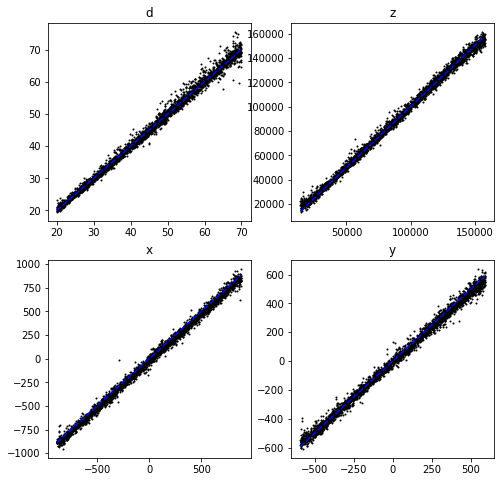

In [17]:
validation_data = {}
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
    validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
    validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("error_scatter_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")
validation_data_df = pd.DataFrame(validation_data)
validation_data_df.to_csv('validation_data_'+ds_file.replace(".nc","_")+''.join(all_labels.columns)+'.txt')
# for a, ax in enumerate(axes.ravel()):
    

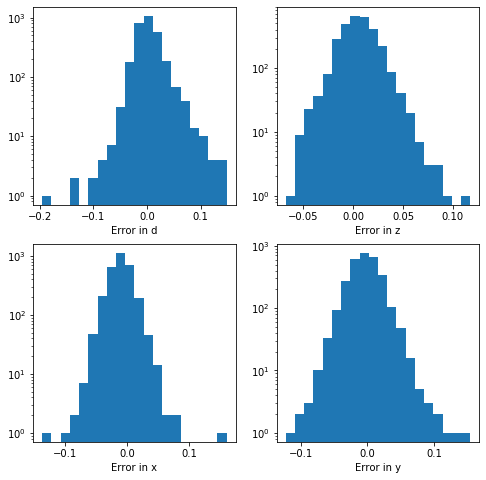

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+test_labels.columns[a])
plt.savefig("relative_error_histogram_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")

In [19]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

array([8.4014386e-01, 2.0951899e+03, 2.7920187e+01, 2.0841047e+01],
      dtype=float32)

In [20]:
np.mean(preds_original[split_index:] - test_labels.values, axis=0)

array([ 1.7097172e-01,  8.3460474e+02, -1.7686333e+01, -3.6482024e+00],
      dtype=float32)

In [21]:
np.std(preds_original[split_index:] - test_labels.values, axis=0)

array([1.1982697e+00, 2.6187170e+03, 3.1572021e+01, 2.7181566e+01],
      dtype=float32)

In [22]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

array([0.01681193, 0.01455175, 0.01575154, 0.01764906])

In [23]:
ds["xsize"]

<xarray.DataArray 'xsize' (xsize: 600)>
array([  0,   1,   2, ..., 597, 598, 599])
Dimensions without coordinates: xsize